In [67]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py
from copy import deepcopy
import os
import json
import gc 
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.utils import dense_to_sparse

from sca import *
from utils import *
from models_uf import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data

In [95]:
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    print(handle['input'].keys())
    Hs = handle['input']["channel_to_noise_matched"][...]
    print(handle['input']['PdB'][...])
    

2021-01-06 23:21:21 | <KeysViewHDF5 ['Channels', 'PA inefficency', 'Pc', 'PdB', 'Relative Tolerance', 'channel_to_noise_matched', 'epsilon']>
2021-01-06 23:21:21 | [-40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23
 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5
  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10]


In [97]:
np.array(range(-40,10+1,1))

array([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
       -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10])

In [74]:
# train data
dfn3 = '../../data_my/channels-HataSuburban-10.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    print(handle['input'].keys())
    Hs = handle['input']["channel_to_noise_matched"][...]
    
Hs.shape

2021-01-06 21:55:07 | <KeysViewHDF5 ['channel', 'channel_to_noise_matched']>


(1000, 10, 10)

In [82]:
karwgs = {'mu':10}
extract_args = lambda a, k: a if not k in karwgs else karwgs[k]
PdB = extract_args(np.array(range(-30,20+1,1)), 'PdB')
mu = extract_args(4.0, 'mu')
Pc = extract_args(1.0, 'Pc')

PdB, mu, Pc


(array([-30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
        -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
         -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
          9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20]),
 10,
 1.0)

In [2]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cpu')

# # train data
# dfn3 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn3, "r") as handle:
#     X_tr = handle['training']['input'][...]
#     y_tr = handle['training']['xopt'][...]
    
# # validation data
# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]
      
        
#--- data---


# train data
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    assert num_ue==Hs.shape[1]

    for hidx in trange(Hs.shape[0]):
        edge_index_tr, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_tr.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_tr.append(xopt[hidx,...] )                   

y_tr = np.concatenate((y_tr))
X_tr = np.concatenate((X_tr))
y_tr = y_tr[~np.any(np.isnan(X_tr),-1)]     
X_tr = X_tr[~np.any(np.isnan(X_tr),-1)]


# validation data
dfn4 = '../../data/results_hataUrban.h5'
X_va, y_va = [],[]
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    for hidx in trange(Hs.shape[0]):
        edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_va.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_va.append(xopt[hidx,...] )

y_va = np.concatenate((y_va))
X_va = np.concatenate((X_va))
y_va = y_va[~np.any(np.isnan(X_va),-1)]     
X_va = X_va[~np.any(np.isnan(X_va),-1)]

#--- (end)---

        
# to toech tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_va = torch.from_numpy(y_va).float().to(device)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)



2020-12-29 17:11:03 | (51000, 17) torch.Size([51000, 4])
2020-12-29 17:11:03 | (51000, 17) torch.Size([51000, 4])


(array([9.8677e+04, 3.3392e+04, 3.6991e+04, 2.0696e+04, 9.4000e+03,
        3.3840e+03, 1.0410e+03, 3.2400e+02, 5.7000e+01, 3.8000e+01]),
 array([0.        , 0.01648412, 0.03296825, 0.04945238, 0.0659365 ,
        0.08242062, 0.09890475, 0.11538888, 0.131873  , 0.14835712,
        0.16484125], dtype=float32),
 <BarContainer object of 10 artists>)

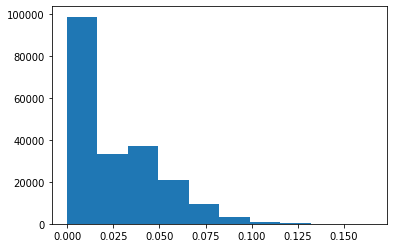

In [3]:
plt.hist(y_tr.numpy().flatten())

## unfolded sca pipeline

In [10]:
from models_uf import *


device = torch.device('cpu')

in_size = num_ue**2 + num_ue + 1
out_size = num_ue

# h_sizes = [128, 64, 32, 16, 8]
# activs = ['elu', 'relu', 'elu', 'relu',  'elu']

h_sizes = [128, 64, 32, 32, 32, 16, 8]
h_sizes = [32, 16, 16, 16, 16, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 512
num_l = 3 # 1 2 3
nepochs = 200
learning_rate = 0.001

init = 'rand'
rseed= 42
loss_which= ['mse','wsee'] # wsee, mse
architecture = USCA_MLP # USCA_MLP_R, USCA_MLP
inner_optim='learned-mlp'

mstr = architecture.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
fix='large_%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
    mstr, k_fold, bs, num_l, learning_rate, init, '+'.join(loss_which), rseed)

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)
tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # clear cache
    torch.cuda.empty_cache()
    X_train, y_train, X_valid, y_valid, X_test, y_test, model = [None for _ in range(7)]
    gc.collect()
#     if k<1:
#         continue
#     # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    tr_wsee[k], va_wsee[k], te_wsee[k] = [],[],[]
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
    print('%d-fold: train opt wsee %.6f / val opt wsee %.6f / test opt wsee %.6f'%(
            k+1, tr_wsee_opt[k], va_wsee_opt[k], te_wsee_opt[k]))
    
    
    model = architecture(num_l, in_size, out_size, h_sizes, activs=activs, channel_info={'mu':mu, 'Pc':Pc},
                     dropout=0, inner_optim='learned-mlp').to(device)
    print(count_parameters(model))
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
#     raise
    
    
    best_wsee = 0
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss, running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = y_train[perm_i[i_s:i_e]]
            x = X_train[perm_i[i_s:i_e]]

            y_pred, gamma = model(x)
            
            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, x, mu, Pc, 'vector')

            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.mean(wsee).item()*num_ue

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss[k].append(running_loss/(i+1))
        tr_wsee[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        yp_valid, gamma = model( X_valid )        
        vloss = torch.mean((yp_valid[-1]-y_valid)**2).item()
        vobj = f_wsee_torch(yp_valid[-1], X_valid, mu, Pc, 'mean').item()
        va_loss[k].append(vloss) 
        va_wsee[k].append(vobj) 

        # test
        yp_test, gamma = model( X_test )
        tloss = torch.mean((yp_test[-1]-y_test)**2).item()
        tobj = f_wsee_torch(yp_test[-1], X_test, mu, Pc, 'mean').item()
        te_loss[k].append(tloss) 
        te_wsee[k].append(tobj)      

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        print('%d: train wsee %.6f / val wsee %.6f / test wsee %.6f'%(
            epoch, tr_wsee[k][-1], va_wsee[k][-1], te_wsee[k][-1]), end=' ') 
        
        # save 
        if va_wsee[k][-1] > best_wsee:
            best_wsee = va_wsee[k][-1]
            torch.save(model, './results/%s.%df.%dep.pt'%(fix, k, epoch))
            print('*')
        else:
            print()
        
        
#     break




2020-12-27 17:21:27 | torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])
2020-12-27 17:21:27 | 1-fold: train opt wsee 7.876275 / val opt wsee 7.827026 / test opt wsee 9.227342
2020-12-27 17:21:27 | 14952


2020-12-27 17:21:28 | 0: train loss 0.195922 / val loss 0.008060 / test loss 0.005307
2020-12-27 17:21:28 | 0: train wsee 4.655436 / val wsee 4.992714 / test wsee 5.169072 2020-12-27 17:21:28 | *



KeyboardInterrupt: 

In [12]:
len(yy)

4

In [62]:
yy, gg = model(X_valid)
y_diff = [yy[i+1] - y_valid for i in range(3)]

fig, ax = plt.subplots(1,3,figsize=(15,3), dpi=200)

for i in range(len(y_diff)):
    ax[i].plot(y_diff[i].detach().numpy(), gg[i].detach().numpy(),'.', alpha=1)
    ax[i].set_title('@ output of unfolded sca block #%d'%(i+1))
    ax[i].set_xlabel('pt_diff ( = pt_%d - pt_opt)'%(i+1))
    ax[i].set_ylabel('gamma_%d'%(i+1))
plt.show()

##

plt.figure(figsize=(10,2), dpi=200)

plt.subplot(131)
plt.hist(y_valid.numpy())#, bins=30)
plt.yscale('log')
plt.title('pt valid (opt)')

plt.subplot(132)
yyy = deepcopy(yy[-1].detach().numpy())
# yyy[yyy>1.6]=0
plt.hist(yyy)#, bins=30)
plt.yscale('log')
plt.title('pt valid (prediction)')

ggg = deepcopy(np.array([gi.detach().numpy() for gi in gg]))
plt.subplot(133)
plt.hist(ggg.reshape(-1,ggg.shape[-1]))#, bins=30)
plt.yscale('log')
plt.title('gamma')

plt.show()

yyy,ggg = None, None
gc.collect()

TypeError: forward() missing 2 required positional arguments: 'edge_index' and 'edge_weights'

In [10]:
moel = torch.save(model, './results/%s.%df.%dep.pt'%(fix, k, epoch))


In [42]:
va_wsee[k][-1], va_wsee[k][-2]

(7.338975429534912, 7.383155822753906)

In [90]:
import os
import json

list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

save_name  = save_dir+'log.%dfcv.json'%k_fold
with open(save_name, 'w') as fp:
    evals = {'tr_loss':tr_loss, 'va_loss':va_loss, 'te_loss':te_loss, 
             'tr_wsee':tr_wsee, 'va_wsee':va_wsee, 'te_wsee':te_wsee}
    json.dump(evals, fp)
    
save_name

'./results/large_USCA.MLP+learned.mlp_kf+2_bs+512_nl+3_lr+1.000000e-03_pinit+rand_loss+mse+wsee_rseed+42/log.2fcv.json'

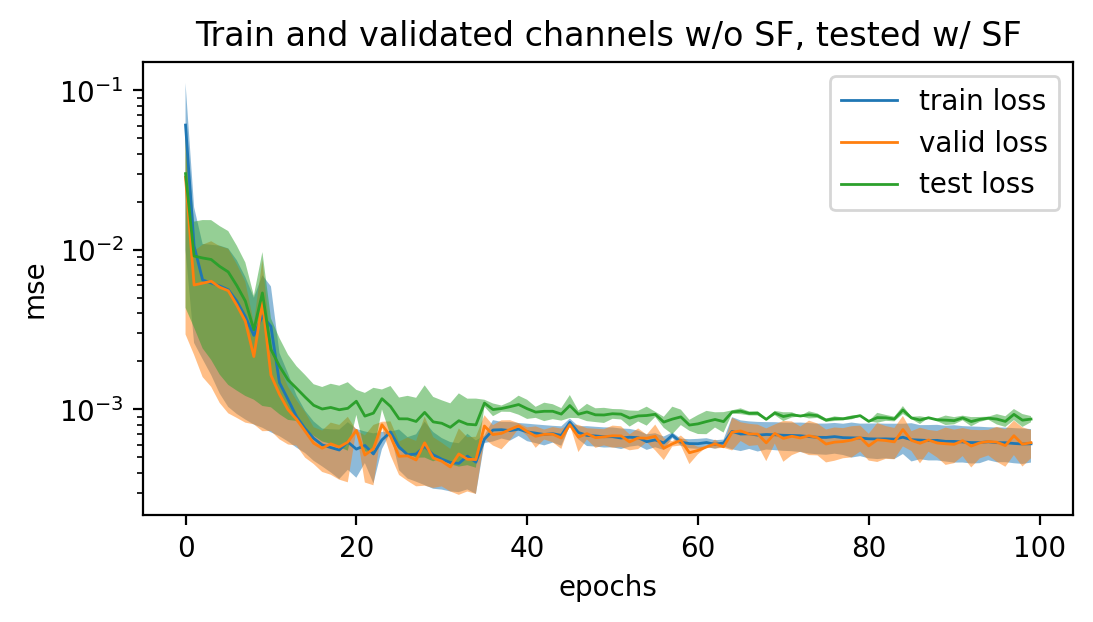

In [61]:

plt.figure(figsize=(6,3),  dpi=200)

for ph, loss in zip(["train", "valid", "test"],[tr_loss1, va_loss1, te_loss1]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

NameError: name 'va_wsee_opt' is not defined

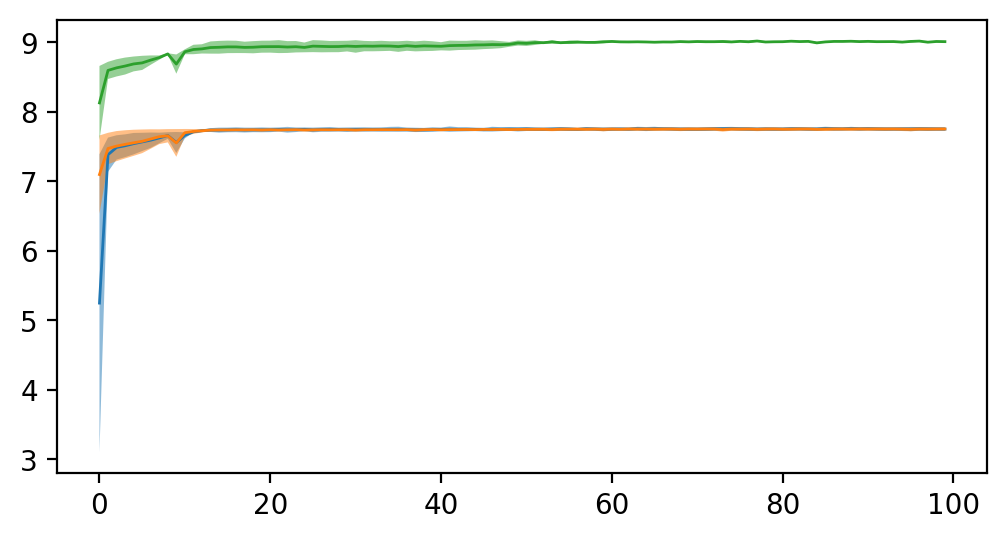

In [62]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(6,3),  dpi=200)

# for i, (ph, loss) in enumerate(zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss])):
for i, (ph, loss) in enumerate(zip(["train", "valid", "test"],[tr_wsee1, va_wsee1, te_wsee1])):

#     plt.plot(range(epoch+1), list(loss.values())[-1], '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.plot([0, epoch], [va_wsee_opt[0]]*2, '--', linewidth=1, label='val/train wsee (opt)',color=colors[1])
plt.plot([0, epoch], [te_wsee_opt[0]]*2, '--', linewidth=1, label='test opt wsee (opt)',color=colors[2])



plt.xlabel('epochs')
plt.ylabel('wsee')
# plt.legend()

# plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
it_count1  = []

def SCA(h, mu, Pc, Pmax, pt = None, MaxIter = 10000, SolverMaxIter = 1000,
         parm_alpha = 1e-8, parm_beta = 0.01, 
         RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd'):
    """
    InnerOpt: sgd, cvx, ...
    Init    : last, full, ...
    """

    if pt is None:
        pt = np.full(h.shape[-1], Pmax)

    def f(p): # verified
        s = h * p # (4,4) * (4,) --> (4,4)
        
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        ee = rates / (mu * p + Pc)

        return np.sum(ee)

    def gradr(p): # verified
        s = h * p
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)
        fac = np.diag(s) / (tmp * tmp2)
        
        grad = h.copy()      
        grad = -(fac * grad.T).T
    
        grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

        return grad

    def gradf(p): # verified
        tmp = 1 / (mu * p + Pc)
        gr = gradr(p)
        
        t1 = np.sum((gr.T * tmp).T, axis=0)

        s = h * p
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        
        t2 = mu * rates * tmp**2

        return t1 - t2

    # gradient step parameter
    if InnerOpt.lower() == "sgd":
        inner_opt = inner_optim_sgd
        kargws = {"learning_rate":.1}
        
    elif InnerOpt.lower() == "cvx":
        inner_opt = inner_optim_cvx
        kargws = {"verbose": False}
        
    else:
        raise NotImplemented
        
        
    OBJ, PT = [f(pt)],[pt]
    cnt = 0
    while True:
                
        cnt += 1
        pvar = inner_opt(pt, h, Pmax, Pc, mu, eps=1e-8, max_iters=SolverMaxIter, **kargws)
                
        # calculate gradient step
        Bpt = pvar - pt
        gamma = 1

        old_obj = f(pt)
        old_pt = pt
        while f(pt + gamma * Bpt) < old_obj + parm_alpha * gamma * gradf(pt) @ Bpt:
            gamma *= parm_beta

#         pt = np.clip(gamma * Bpt + pt, 0, Pmax)
        pt += gamma * Bpt
        obj = f(pt)
        
        OBJ.append(obj)
        PT.append(pt)

        with np.errstate(divide='ignore'):
            if abs(obj/old_obj - 1) < RelTolFun and np.linalg.norm(pt-old_pt, np.inf) / np.linalg.norm(pt, np.inf) < RelTolVal:
                break
        
        if cnt > MaxIter:
            print('MaxIter')
            break

    it_count1.append(cnt)
    return (OBJ, PT)

In [ ]:
it_count1

In [ ]:

num_ue = 7
mu = 4
Pc = 1

INITS = ['last','full']#,'rand']
OPTIM = ['sgd', 'cvx']

INNER_MAXIT = [6]#, 2, 5, 10, 15, 20, 35, 50, 100, 150, 200]
# outer_maxit = [1, 2, 5, 10, 20, 50, 150]

log_outiters = dict(zip(INITS,[[] for _ in INITS]))
log_all = dict(zip(OPTIM,[[] for _ in OPTIM]))

for opt in OPTIM:
    
    for im in INNER_MAXIT:

        log_monitor = {
            'objective':dict(zip(INITS,[[] for _ in INITS])),
            'pwr_alloc':dict(zip(INITS,[[] for _ in INITS]))
        }


        dfn1 = '../../data/wsee%d-processed.h5'%num_ue
        with h5py.File(dfn1, "r") as f:
            PdB = f['input']['PdB'][...] # this is fixed

        assert np.allclose(PdB, np.array(range(-30,20+1,1)))
        Plin = 10**(np.asarray(PdB/10))

        dfn2 = '../../data_my/channels-%d.h5'%num_ue
    #     dfn2 = '../../data_my/channels-HataSuburban-%d.h5'%num_ue
        with h5py.File(dfn2, "r") as f:
            # Get the data
            data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}

            Hs = data['input']['channel_to_noise_matched']

            for hidx in tqdm([456]):#trange(Hs.shape[0]):#tqdm(np.random.permutation(Hs.shape[0])):

                h = Hs[hidx]
                pt = None

                p_perm = list(range(len(Plin)))#
                for pidx in tqdm(p_perm, desc=str(im)):

                    p = Plin[pidx]

                    O = dict(zip(INITS,[[] for _ in INITS]))
                    P = dict(zip(INITS,[[] for _ in INITS]))
                    
                    for istr in INITS: #['last','full']
                        if istr == 'last' and pt is not None:
                            p0 = pt
                        elif istr == 'full' or pt is None:
                            p0 = np.full(num_ue, p)
                        else:
                            raise NotImplemented
                            
                        try:
                            assert istr == 'last' # dont do full 
                            O[istr], P[istr] = SCA(h, mu, Pc, Pmax = p, pt = p0, 
                                                    SolverMaxIter=im, MaxIter = 1000, 
                                                    parm_alpha = 1e-8, parm_beta = 0.01, 
                                                    RelTolFun = 1e-12, RelTolVal = 1e-12, 
                                                    InnerOpt=opt)
                        except:
                            O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
                            
                    # best init
                    bstr = max(O, key=lambda key: O[key][-1]) 
                    pt = P[bstr][-1]

                    print('%s init is best!'%bstr.upper(), 
                          '; objective ee =', O[bstr][-1], 
                          '; #outer iters =', len(O[bstr]),
                          '; pt =', pt, '; Pmax =', p)

                    [log_monitor['objective'][k].append(v) for k,v in O.items()]
                    [log_monitor['pwr_alloc'][k].append(v) for k,v in P.items()]

                break

            lens = {}
            for k,v in log_monitor['objective'].items():
                lens[k] = np.array([len(vv) for vv in v])

            eeval = {}
            for k,v in log_monitor['objective'].items():
                eeval[k] = np.array([vv[-1] for vv in v])

            for k,v in log_monitor['objective'].items():
                length = [len(vv) for vv in v]
                ee = eeval[k][eeval[k]>=0]

                print(k)
                print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
                print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
                print()
                log_outiters[k].append(length)
                
    log_all[opt] = deepcopy(log_monitor)


In [65]:
torch.stack(.1)+torch.Tensor([1,2,3])

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not float

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=200)
for i, (k,v) in enumerate(log_outiters.items()): 
    ax[i].boxplot(np.array(v).T, showmeans=True)

    ax[i].set_title(k)
    ax[i].set_xticks(range(1,len(INNER_MAXIT)+1))
    ax[i].set_xticklabels(INNER_MAXIT)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('# inner iters')
    
ax[0].set_ylabel('# outer iters')
# plt.legend()
plt.show()

In [ ]:

# visualize channels and plin

H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/50 for u,v in edges]

plt.figure(figsize=(13,4))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin,'.')
plt.ylabel('P_max')
plt.show()




In [ ]:
plt.figure(figsize=(10,4), dpi=200)

plt.plot([v[-1] for v in log_all['sgd']['objective']['last']], '.', alpha=.7, label='sgd')
plt.plot([v[-1] for v in log_all['cvx']['objective']['last']], '.', alpha=.7, label='cvx')

plt.legend()
plt.show()

In [ ]:
lens = {}
for k,v in log_monitor['objective'].items():
    lens[k] = np.array([len(vv) for vv in v])

eeval = {}
for k,v in log_monitor['objective'].items():
    eeval[k] = np.array([vv[-1] for vv in v])
    
for k,v in log_monitor['objective'].items():
    length = [len(vv) for vv in v]
    ee = eeval[k][eeval[k]>=0]
    
    print(k)
    print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
    print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
    print()
    
    
# # plot ee
# for k,v in log_monitor['objective'].items():
#     plt.plot(p_perm, eeval[k],'.', label=k, alpha=.7)
# #     plt.plot(eeval[k],'.', label=k, alpha=.7)
# plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
# plt.legend()
# plt.show()

# MLP

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F

from tqdm.auto import trange

# layer = ([128, 64, 32, 16, 8], ['elu', 'relu', 'elu', 'relu', 'elu'])
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # permutation
        self.fc1 = nn.Linear(input_size**2+1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, input_size)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.elu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc4(x))
        x = self.elu(self.fc5(x))
        x = self.fc6(x)
        
        x = scale_to_range(x, [0, x[:,-1]])
        
        return x
    
    
class GCN(torch.nn.Module):
    def __init__(self, dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim, 32)
        self.conv2 = GCNConv(32, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 16)
        self.conv5 = GCNConv(16, 8)
        self.conv6 = GCNConv(8, dim)
        self.final = nn.Linear(dim, dim) 

    def forward(self, x, edge_index, edge_weights):
#         x, edge_index = data.x, data.edge_index

        x = F.elu(self.conv1(x, edge_index, edge_weight=edge_weights))
        
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weights))
        
        x = F.elu(self.conv3(x, edge_index, edge_weight=edge_weights))
        
        x = F.relu(self.conv4(x, edge_index, edge_weight=edge_weights))
        
        x = F.elu(self.conv5(x, edge_index, edge_weight=edge_weights))

        x = self.conv6(x, edge_index, edge_weight=edge_weights)

#         return F.log_softmax(x, dim=1)
        return self.final(x)


    
count_parameters(MLP(num_ue),1)
count_parameters(GCN(1),1)

2020-12-29 17:11:33 | Total Trainable Params: 13340
2020-12-29 17:11:33 | Total Trainable Params: 13731


13731

In [83]:
count_parameters(model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
| sca.0.gamma.hidden.0.weight  |    2688    |
|  sca.0.gamma.hidden.0.bias   |    128     |
| sca.0.gamma.hidden.2.weight  |    8192    |
|  sca.0.gamma.hidden.2.bias   |     64     |
| sca.0.gamma.hidden.5.weight  |    2048    |
|  sca.0.gamma.hidden.5.bias   |     32     |
| sca.0.gamma.hidden.8.weight  |    1024    |
|  sca.0.gamma.hidden.8.bias   |     32     |
| sca.0.gamma.hidden.11.weight |    1024    |
|  sca.0.gamma.hidden.11.bias  |     32     |
| sca.0.gamma.hidden.14.weight |    512     |
|  sca.0.gamma.hidden.14.bias  |     16     |
| sca.0.gamma.hidden.17.weight |    128     |
|  sca.0.gamma.hidden.17.bias  |     8      |
| sca.0.gamma.hidden.20.weight |     32     |
|  sca.0.gamma.hidden.20.bias  |     4      |
| sca.0.optim.hidden.0.weight  |    2688    |
|  sca.0.optim.hidden.0.bias   |    128     |
| sca.0.optim.hidden.2.weight  |  

95784

# GCN LEARNING

In [47]:
%load_ext autoreload
%autoreload 2

#--- data---
import dataset as ds
import torch
import numpy as np
from utils import init_p

num_ue=4
init = 'full'
device = torch.device('cuda')


dfn_tr = '../../data/results_hataUrban_noSF.h5' # train / validation data
X_tr, y_tr, cinfo_tr = ds.load_data(dfn_tr)
print(X_tr.shape, y_tr.shape)

dfn_te = '../../data/results_hataUrban.h5' # test data
X_te, y_te, cinfo_te = ds.load_data(dfn_te)
print(X_te.shape, y_te.shape)

# to torch tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_te = torch.from_numpy(y_te).float().to(device)

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((init_p(x[:,-1], num_ue, method=init), x))).float().to(device)
X_tr_ = attach_pt(X_tr)
X_te_ = attach_pt(X_te)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items() }
cinfo_tr = dict_to_device(cinfo_tr, device)
cinfo_te = dict_to_device(cinfo_te, device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(51000, 17) (51000, 4)
(51000, 17) (51000, 4)


In [58]:
from models_uf import GCN_ChPt
from utils import f_wsee_torch
from tqdm.notebook import trange

mu=4 
Pc=1

h_sizes = [32, 128, 64, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu',  'elu']

# k_fold = 2
# bs = 512
# num_l = 3 # 1 2 3
nepochs = 100
learning_rate = 0.001

# init = 'rand'
# rseed= 42
loss_which= ['mse','wsee'] # wsee, mse
# architecture = USCA_MLP # USCA_MLP_R, USCA_MLP
# inner_optim='learned-mlp'
    
k_fold = 2
bs = 512

import numpy as np
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss1, va_loss1, te_loss1 = {},{},{}
tr_wsee1, va_wsee1, te_wsee1 = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):

    X_train, y_train, model = None, None, None
    torch.cuda.empty_cache()
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_te_[valid_index], y_te[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss1[k], va_loss1[k], te_loss1[k] = [],[],[]
    tr_wsee1[k], va_wsee1[k], te_wsee1[k] = [],[],[]
    
#     model = GCN(1).to(device)
    model = GCN_ChPt(in_size=1, out_size=1, h_sizes=h_sizes, activs=activs, channel_info = cinfo_tr).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])
        
        shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long().to(device)        

        running_loss,running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs
            idx = perm_i[i_s:i_e]

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long().to(device)    
            edge_index_batch = (cinfo_tr['edge_index'].repeat(1, bs).to(device)+shift)#.to(device) #edge_index_tr=edge_index_va
            y_init = X_train[idx,:num_ue] # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = X_train[idx,num_ue:-1].reshape(-1).float()            
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_train[idx].float().to(device)
            y_pred = model([signal]*2, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
            
            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, X_train[idx], mu, Pc, 'vector')
            
            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.sum(wsee).item()
#             raise

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss1[k].append(running_loss/(i+1))
        tr_wsee1[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        bs_va = bs#y_valid.shape[0]
        running_loss,running_wsee = 0,0
        for i in range(y_valid.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long().to(device)
            edge_index_batch = (cinfo_tr['edge_index'].repeat(1, bs_va).to(device)+shift)#.to(device) #edge_index_tr=edge_index_va
            y_init = X_valid[i_s:i_e,:num_ue].to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = X_valid[i_s:i_e,num_ue:-1].reshape(-1).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_valid[i_s:i_e].to(device)
            y_pred = model([signal]*2, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
            wsee = f_wsee_torch(y_pred, X_valid[i_s:i_e], mu, Pc, 'vector')

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            running_wsee += torch.sum(wsee).item()
            
        va_loss1[k].append(running_loss/(i+1))
        va_wsee1[k].append(running_wsee/(i+1))

        # test
        bs_va = bs#y_va.shape[0]
        running_loss,running_wsee = 0,0
        for i in range(y_test.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long().to(device)
            edge_index_batch = (cinfo_te['edge_index'].repeat(1, bs_va).to(device)+shift)#.to(device) #edge_index_tr=edge_index_va

            y_init = X_test[i_s:i_e,:num_ue].to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            
            edge_weight_batch = X_test[i_s:i_e,num_ue:-1].reshape(-1).float().to(device)       
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_test[i_s:i_e].float().to(device)
            y_pred = model([signal]*2, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
            wsee = f_wsee_torch(y_pred, X_test[i_s:i_e], mu, Pc, 'vector')

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            running_wsee += torch.sum(wsee).item()
            
        te_loss1[k].append(running_loss/(i+1))
        te_wsee1[k].append(running_wsee/(i+1))
        
        # -------

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss1[k][-1], va_loss1[k][-1], te_loss1[k][-1]))
        print('%d: train wsee %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_wsee1[k][-1], va_wsee1[k][-1], te_wsee1[k][-1]))
        
        

torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])


0: train loss 0.111265 / val loss 0.054183 / test loss 0.055829
0: train wsee 3.106253 / val loss 6.535413 / test loss 7.596567
1: train loss 0.018548 / val loss 0.009847 / test loss 0.015044
1: train wsee 7.137093 / val loss 7.246392 / test loss 8.472701
2: train loss 0.010892 / val loss 0.010777 / test loss 0.015384
2: train wsee 7.313014 / val loss 7.290797 / test loss 8.509109
3: train loss 0.010769 / val loss 0.011334 / test loss 0.015369
3: train wsee 7.347824 / val loss 7.329152 / test loss 8.536964
4: train loss 0.010632 / val loss 0.010563 / test loss 0.014104
4: train wsee 7.387872 / val loss 7.366916 / test loss 8.582490
5: train loss 0.010218 / val loss 0.010148 / test loss 0.013122
5: train wsee 7.435927 / val loss 7.405576 / test loss 8.602596
6: train loss 0.008619 / val loss 0.008126 / test loss 0.010634
6: train wsee 7.482575 / val loss 7.469434 / test loss 8.677487
7: train loss 0.006767 / val loss 0.006318 / test loss 0.008340
7: train wsee 7.548062 / val loss 7.5355

64: train loss 0.000561 / val loss 0.000553 / test loss 0.000940
64: train wsee 7.781330 / val loss 7.728554 / test loss 9.017818
65: train loss 0.000547 / val loss 0.000633 / test loss 0.001015
65: train wsee 7.785479 / val loss 7.726580 / test loss 9.009426
66: train loss 0.000565 / val loss 0.000590 / test loss 0.000971
66: train wsee 7.775556 / val loss 7.727886 / test loss 9.013954
67: train loss 0.000544 / val loss 0.000597 / test loss 0.000974
67: train wsee 7.776770 / val loss 7.728267 / test loss 9.016664
68: train loss 0.000560 / val loss 0.000473 / test loss 0.000856
68: train wsee 7.775993 / val loss 7.722772 / test loss 9.023760
69: train loss 0.000555 / val loss 0.000611 / test loss 0.000978
69: train wsee 7.776373 / val loss 7.726868 / test loss 9.017762
70: train loss 0.000549 / val loss 0.000469 / test loss 0.000845
70: train wsee 7.774030 / val loss 7.725864 / test loss 9.025918
71: train loss 0.000547 / val loss 0.000516 / test loss 0.000889
71: train wsee 7.777942 /

0: train loss 0.010023 / val loss 0.002951 / test loss 0.004331
0: train wsee 7.390061 / val loss 7.660141 / test loss 8.660439
1: train loss 0.002610 / val loss 0.002197 / test loss 0.003258
1: train wsee 7.629490 / val loss 7.698367 / test loss 8.719845
2: train loss 0.002065 / val loss 0.001595 / test loss 0.002413
2: train wsee 7.662961 / val loss 7.723274 / test loss 8.756438
3: train loss 0.001642 / val loss 0.001385 / test loss 0.002044
3: train wsee 7.676106 / val loss 7.734880 / test loss 8.780751
4: train loss 0.001257 / val loss 0.001097 / test loss 0.001653
4: train wsee 7.696246 / val loss 7.742484 / test loss 8.796055
5: train loss 0.001035 / val loss 0.000944 / test loss 0.001424
5: train wsee 7.698827 / val loss 7.746202 / test loss 8.806208
6: train loss 0.000936 / val loss 0.000884 / test loss 0.001311
6: train wsee 7.702369 / val loss 7.748864 / test loss 8.811662
7: train loss 0.000864 / val loss 0.000826 / test loss 0.001214
7: train wsee 7.700252 / val loss 7.7483

64: train loss 0.000893 / val loss 0.000886 / test loss 0.000986
64: train wsee 7.722813 / val loss 7.773950 / test loss 8.992818
65: train loss 0.000853 / val loss 0.000830 / test loss 0.000933
65: train wsee 7.728962 / val loss 7.775539 / test loss 8.993859
66: train loss 0.000841 / val loss 0.000811 / test loss 0.000917
66: train wsee 7.735924 / val loss 7.775513 / test loss 8.996431
67: train loss 0.000834 / val loss 0.000802 / test loss 0.000915
67: train wsee 7.730868 / val loss 7.776026 / test loss 8.992726
68: train loss 0.000832 / val loss 0.000760 / test loss 0.000875
68: train wsee 7.726256 / val loss 7.774564 / test loss 8.997101
69: train loss 0.000831 / val loss 0.000803 / test loss 0.000920
69: train wsee 7.724975 / val loss 7.776367 / test loss 8.996438
70: train loss 0.000826 / val loss 0.000846 / test loss 0.000959
70: train wsee 7.726317 / val loss 7.776057 / test loss 8.997019
71: train loss 0.000825 / val loss 0.000841 / test loss 0.000959
71: train wsee 7.726413 /

In [118]:
from utils import scale_to_range

In [9]:
device = torch.device('cpu')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256

import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss1, va_loss1, te_loss1 = {},{},{}
tr_wsee1, va_wsee1, te_wsee1 = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_te_[valid_index], y_te[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss1[k], va_loss1[k], te_loss1[k] = [],[],[]
    tr_wsee1[k], va_wsee1[k], te_wsee1[k] = [],[],[]
    
#     model = MLP(num_ue).to(device)
    model = GCN(1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)
#     opt = torch.optim.SGD(model.parameters(), lr=0.01)
    
    for epoch in trange(500, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss,running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs
            idx = perm_i[i_s:i_e]

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (cinfo_tr['edge_index'].repeat(1, bs)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = X_train[idx,:num_ue].to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = X_train[idx,num_ue:-1].reshape(-1).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_train[idx].float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
#             y_pred = scale_to_range(y_pred, (0,X_train[idx,-1]))
            
            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, X_train[idx], mu, Pc, 'vector')

            loss = 0.
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.sum(wsee).item()
#             raise

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss1[k].append(running_loss/(i+1))
        tr_wsee1[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        bs_va = bs#y_valid.shape[0]
        running_loss,running_wsee = 0,0
        for i in range(y_valid.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (cinfo_tr['edge_index'].repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va
            y_init = X_valid[i_s:i_e,:num_ue].to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = X_valid[i_s:i_e,num_ue:-1].reshape(-1).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_valid[i_s:i_e].to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
            wsee = f_wsee_torch(y_pred, X_valid[i_s:i_e], mu, Pc, 'vector')

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            running_wsee += torch.sum(wsee).item()
            
        va_loss1[k].append(running_loss/(i+1))
        va_wsee1[k].append(running_wsee/(i+1))

        # test
        bs_va = bs#y_va.shape[0]
        running_loss,running_wsee = 0,0
        for i in range(y_test.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (cinfo_te['edge_index'].repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = X_test[i_s:i_e,:num_ue].to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            
            edge_weight_batch = X_test[i_s:i_e,num_ue:-1].reshape(-1).float().to(device)       
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = y_test[i_s:i_e].float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)
            wsee = f_wsee_torch(y_pred, X_test[i_s:i_e], mu, Pc, 'vector')

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            running_wsee += torch.sum(wsee).item()
            
        te_loss1[k].append(running_loss/(i+1))
        te_wsee1[k].append(running_wsee/(i+1))
        
        # -------

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss1[k][-1], va_loss1[k][-1], te_loss1[k][-1]))
        print('%d: train wsee %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_wsee1[k][-1], va_wsee1[k][-1], te_wsee1[k][-1]))
        
#     break

torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])


0: train loss 0.062794 / val loss 0.018000 / test loss 0.031508
0: train wsee 6.869764 / val loss 7.162690 / test loss 8.086316
1: train loss 0.018072 / val loss 0.011178 / test loss 0.021670
1: train wsee 7.272892 / val loss 7.328943 / test loss 8.285689
2: train loss 0.013418 / val loss 0.015875 / test loss 0.024763
2: train wsee 7.378886 / val loss 7.313383 / test loss 8.289489
3: train loss 0.011061 / val loss 0.017030 / test loss 0.024804
3: train wsee 7.439888 / val loss 7.281529 / test loss 8.245869



KeyboardInterrupt: 

In [128]:
y_pred

tensor([[0.0358, 0.0402, 0.0547, 0.0417],
        [0.0357, 0.0400, 0.0546, 0.0417],
        [0.0359, 0.0395, 0.0549, 0.0413],
        ...,
        [0.0396, 0.0441, 0.0418, 0.0405],
        [0.0396, 0.0445, 0.0413, 0.0419],
        [0.0414, 0.0444, 0.0416, 0.0416]], device='cuda:0',
       grad_fn=<ViewBackward>)

In [46]:
signal.shape, edge_index_batch.shape, y_init.shape, bs_va

(torch.Size([624, 1]), torch.Size([2, 4096]), torch.Size([156, 4]), 256)

In [ ]:
from utils import *
f(y_true[0].cpu().numpy(), h, mu, Pc), f(y_pred[0].detach().cpu().numpy(), h, mu, Pc)

In [ ]:
y_true[0].cpu().numpy(), y_pred[0].detach().cpu().numpy(), Pc

In [ ]:
h * y_true[0].cpu().numpy()

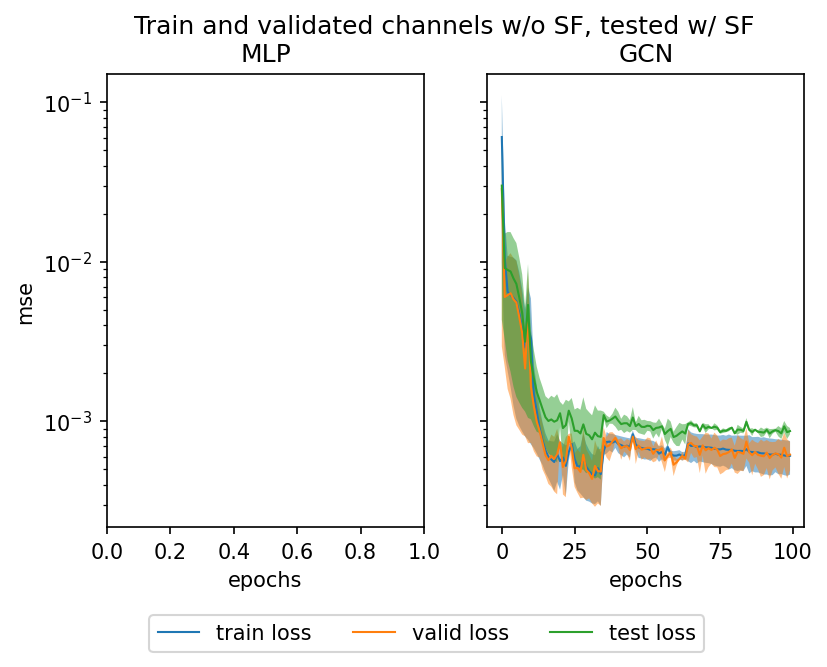

In [59]:

fig, ax = plt.subplots(1,2, dpi=150, sharey=True)

# for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

#     m = np.mean(list(loss.values()),0)
#     e = np.std(list(loss.values()),0)

#     ax[0].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
#     ax[0].fill_between(range(epoch+1), m-e, m+e,
#         alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
#         linewidth=0, label=None)

for ph, loss in zip(["train", "valid", "test"],[tr_loss1, va_loss1, te_loss1]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[1].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[1].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

ax[1].set_xlabel('epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('mse')

ax[0].set_title('MLP')
ax[1].set_title('GCN')

plt.legend(bbox_to_anchor=(0.8,-0.1), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.yscale('log')
plt.suptitle('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [61]:
gamma

tensor([[0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0875, 0.6841, 0.3189],
        ...,
        [0.0000, 0.1299, 0.3753, 0.3838],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.1604, 0.1948, 0.4297]], grad_fn=<MaxBackward2>)

In [5]:
type(X_tr)

numpy.ndarray

In [5]:
import gc

# MLP LEARNING

In [51]:
from models_uf import basic_mlp



in_size = num_ue**2 + 1
out_size = num_ue

# h_sizes = [128, 64, 32, 16, 8]
# activs = ['elu', 'relu', 'elu', 'relu',  'elu']

h_sizes = [128, 64, 32, 32, 20, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

# h_sizes = [256, 256, 64, 64, 32, 32, 32, 32, 8]
# activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 512
num_l = 0 # 1 2 3
nepochs = 200
learning_rate = 0.001

init = 'none'
rseed= 42
loss_which= ['mse','wsee'] # wsee, mse
architecture = basic_mlp#USCA_MLP_R # USCA_MLP_R, USCA_MLP
inner_optim='vanilla'

mstr = architecture.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
fix='small_%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
    mstr, k_fold, bs, num_l, learning_rate, init, '+'.join(loss_which), rseed)

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)
tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):

    # clear cache
    torch.cuda.empty_cache()
    X_train, y_train, X_valid, y_valid, X_test, y_test, model = [None for _ in range(7)]
    gc.collect()
    
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    tr_wsee[k], va_wsee[k], te_wsee[k] = [],[],[]
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
    print('%d-fold: train opt wsee %.6f / val opt wsee %.6f / test opt wsee %.6f'%(
            k+1, tr_wsee_opt[k], va_wsee_opt[k], te_wsee_opt[k]))
    
#     model = architecture(num_ue).to(device)
    model = architecture(in_size, out_size, h_sizes, activs=activs, dropout=0).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    count_parameters(model)
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss, running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = y_train[i_s:i_e] 
            x = X_train[i_s:i_e]
            
            y_pred = model(x[:,num_ue:])
#             print(y_pred)

            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, x, mu, Pc, 'vector')

            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.mean(wsee).item()*num_ue
            
#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())

        tr_loss[k].append(running_loss/(i+1))
        tr_wsee[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        y_pred = model( X_valid[:,num_ue:] )
        va_wsee[k].append(f_wsee_torch(y_pred,  X_valid, mu, Pc, 'mean').item())
        va_loss[k].append(torch.mean(( y_pred-y_valid )**2).item())   

        # test
        y_pred = model( X_test[:,num_ue:] )
        te_wsee[k].append(f_wsee_torch(y_pred,  X_test, mu, Pc, 'mean').item())
        te_loss[k].append(torch.mean((y_pred-y_test)**2).item())

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        print('%d: train wsee %.6f / val wsee %.6f / test wsee %.6f'%(
            epoch, tr_wsee[k][-1], va_wsee[k][-1], te_wsee[k][-1]))
        print()
        
#     break

NameError: name 'os' is not defined

In [110]:
fix 

'small_basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42'

In [111]:

import os
import json

list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

with open(save_dir+'log.%dfcv.json'%k_fold, 'w') as fp:
    evals = {'tr_loss':tr_loss, 'va_loss':va_loss, 'te_loss':te_loss, 
             'tr_wsee':tr_wsee, 'va_wsee':va_wsee, 'te_wsee':te_wsee}
    json.dump(evals, fp)
    
    
save_dir+'log.%dfcv.json'%k_fold

'./results/small_basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json'

In [127]:
save_dir+'log.%dfcv.json'%k_fold


'./results/basic.mlp+vanilla_kf+2_bs+256_nl+0_lr+1.000000e-02_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json'

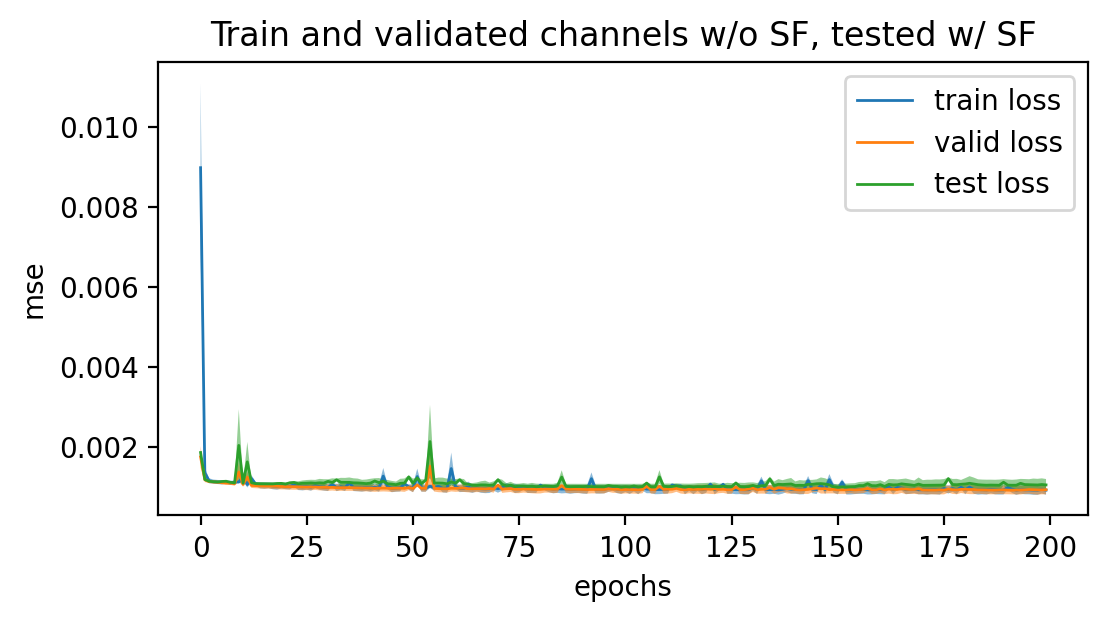

In [117]:

plt.figure(figsize=(6,3),  dpi=200)


for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):
# for ph, loss in zip(["train", "valid", "test"],[tr_wsee, va_wsee, te_wsee]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)


# plt.plot(range(epoch+1), np.mean(list(tr_loss.values()),0), '-', label='train loss')
# plt.plot(range(epoch+1), np.mean(list(va_loss.values()),0), '-', label='validation loss')
# plt.plot(range(epoch+1), np.mean(list(te_loss.values()),0), '-.', label='test loss')

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
ax

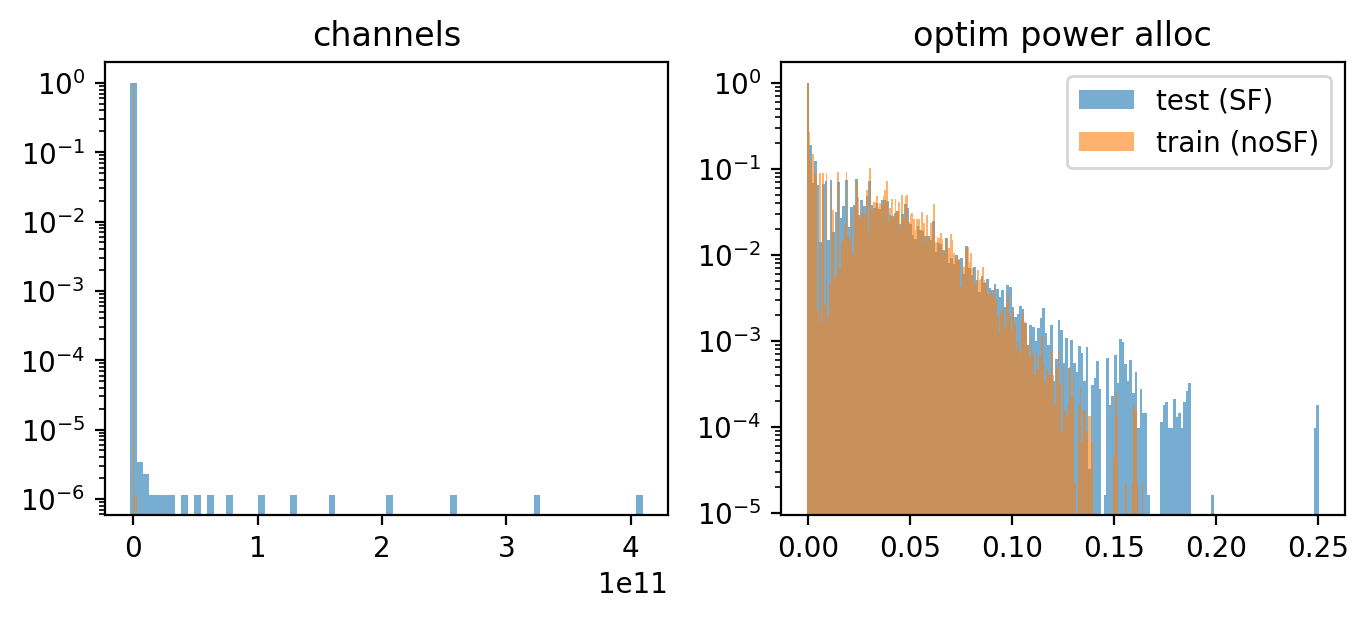

In [60]:
def histogram(sample,bins=10, alpha=1, ax=None, label=None):
    if not bins:
        bins='auto'
    bin_height,bin_boundary = np.histogram(sample,bins=bins)
    width = bin_boundary[1]-bin_boundary[0]
    bin_height = bin_height/float(max(bin_height))
    if ax is not None:
        ax.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)
    else:
        plt.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)


fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=200)#, sharex=False, sharey=False)

histogram(X_va.flatten(),bins=80, alpha=.6, ax=ax[0], label='test')
histogram(X_tr.flatten(),bins=80, alpha=.6, ax=ax[0], label='train')

histogram(y_va.flatten(),bins=200, alpha=.6, ax=ax[1], label='test (SF)')
histogram(y_tr.flatten(),bins=200, alpha=.6, ax=ax[1], label='train (noSF)')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_title("channels")
ax[1].set_title("optim power alloc")

# plt.title("Data - hataUrban")
plt.legend()
plt.show()




In [ ]:
plt.hist(np.random.randn(300,3))


In [ ]:
plt.plot(p_perm, ee[14], '.', label='mlp', alpha=.7)
#     plt.plot(eeval[k],'.', label=k, alpha=.7)
plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
plt.legend()
plt.show()

In [ ]:
p0, Pmax, model.pvar
f(model.pvar.detach().numpy(), h0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()